Untuk dataset : https://drive.google.com/file/d/1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM/view?usp=sharing

fyi dataset yang ada di sini adalah dataset yang udah aku gabungin dari beberapa dataset yang ada di kaggle

dataset 1 : https://www.kaggle.com/datasets/nandanp6/cataract-image-dataset

dataset 2 : https://www.kaggle.com/datasets/akshayramakrishnan28/cataract-classification-dataset (full cataract)

dataset 3 : https://www.kaggle.com/datasets/himaniac/cataract-eye-dataset

Importing Dependencies

In [1]:
# Mengimpor Dependensi (contoh, Anda akan memiliki lebih banyak)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 # Contoh model pre-trained
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
def set_all_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed diatur ke {seed}")

set_all_seeds(42)

Random seed diatur ke 42


In [3]:
!gdown --id 1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM
From (redirected): https://drive.google.com/uc?id=1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM&confirm=t&uuid=89adb40f-7641-4a72-bda5-597874fb466e
To: /content/dataset.zip
100% 553M/553M [00:08<00:00, 67.8MB/s]


In [4]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: test/
   creating: test/cataract/
  inflating: test/cataract/image_246.png  
  inflating: test/cataract/image_247.png  
  inflating: test/cataract/image_248.png  
  inflating: test/cataract/image_249.png  
  inflating: test/cataract/image_250.png  
  inflating: test/cataract/image_251.png  
  inflating: test/cataract/image_252.png  
  inflating: test/cataract/image_253.png  
  inflating: test/cataract/image_254.png  
  inflating: test/cataract/image_255.png  
  inflating: test/cataract/image_256.png  
  inflating: test/cataract/image_257.png  
  inflating: test/cataract/image_258.png  
  inflating: test/cataract/image_259.png  
  inflating: test/cataract/image_260.png  
  inflating: test/cataract/image_261.png  
  inflating: test/cataract/image_262.png  
  inflating: test/cataract/image_263.png  
  inflating: test/cataract/image_264.png  
  inflating: test/cataract/image_265.png  
  inflating: test/cataract/image_266.png  
  inflating: test/cataract/i

In [5]:
# Hitung jumlah gambar
train_cataract = len(os.listdir("/content/train/cataract"))
train_normal = len(os.listdir("/content/train/normal"))
test_cataract = len(os.listdir("/content/test/cataract"))
test_normal = len(os.listdir("/content/test/normal"))

print(f"Train - Cataract: {train_cataract}, Normal: {train_normal}")
print(f"Test - Cataract: {test_cataract}, Normal: {test_normal}")


Train - Cataract: 874, Normal: 412
Test - Cataract: 61, Normal: 60


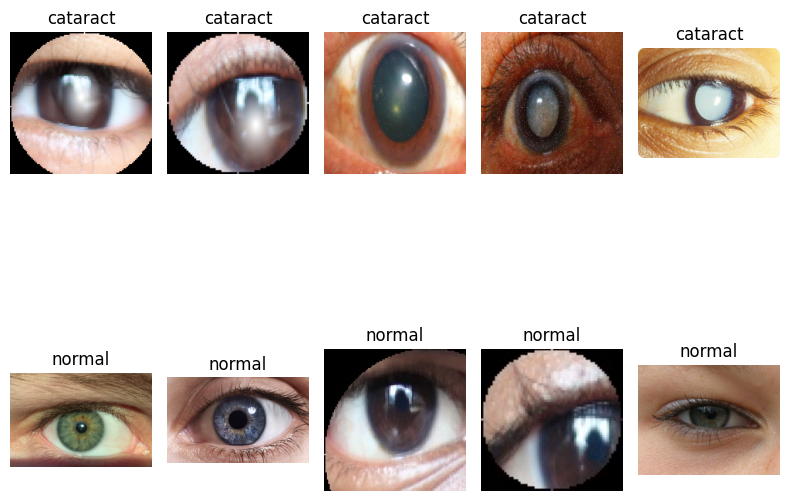

In [6]:
# Buat kamus berisi list nama file gambar per kelas
Prediction_image = {}
path = "/content/train"  # path ke folder train

for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        Prediction_image[class_name] = os.listdir(class_path)

# Tampilkan 2 gambar acak per kelas
num_classes = len(Prediction_image)
fig, axs = plt.subplots(num_classes, 5, figsize=(8, 4 * num_classes))

for i, (class_name, image_list) in enumerate(Prediction_image.items()):
    # ambil 2 gambar acak
    images = np.random.choice(image_list, 5, replace=False)
    for j, img_name in enumerate(images):
        img_path = os.path.join(path, class_name, img_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img,cmap='gray')  # atau hilangkan cmap='gray' untuk warna asli
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

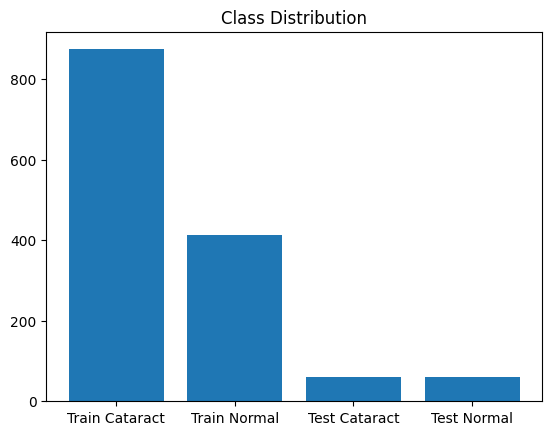

In [7]:
# Plot distribusi
plt.bar(["Train Cataract", "Train Normal", "Test Cataract", "Test Normal"],
        [train_cataract, train_normal, test_cataract, test_normal])
plt.title("Class Distribution")
plt.show()

Max Width: 5184, Min Width: 53
Max Height: 3456, Min Height: 53


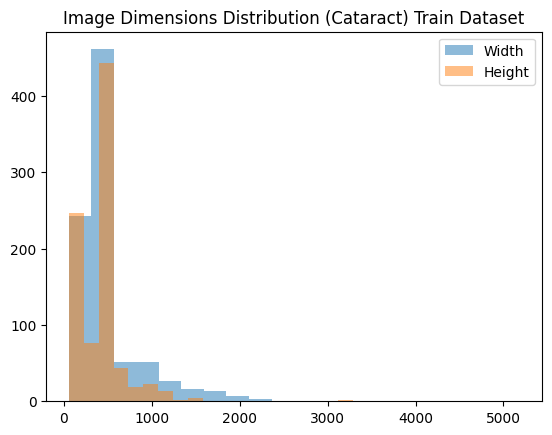

In [8]:
def analyze_image_stats(folder_path):
    widths, heights = [], []
    for img_file in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, img_file))
        widths.append(img.width)
        heights.append(img.height)
    return widths, heights

widths, heights = analyze_image_stats("/content/train/cataract")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Cataract) Train Dataset")
plt.show()

Max Width: 5739, Min Width: 41
Max Height: 3826, Min Height: 36


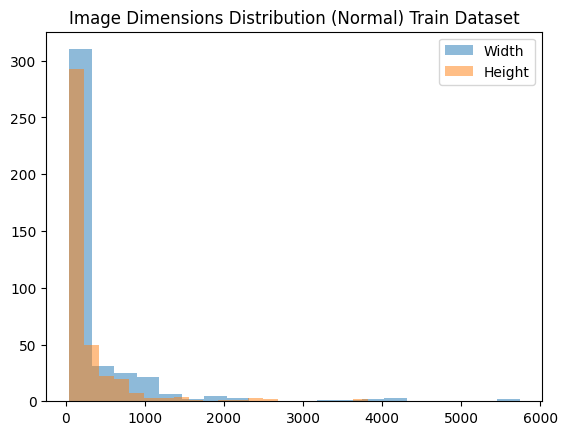

In [9]:
widths, heights = analyze_image_stats("/content/train/normal")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Normal) Train Dataset")
plt.show()

Max Width: 6622, Min Width: 200
Max Height: 3120, Min Height: 136


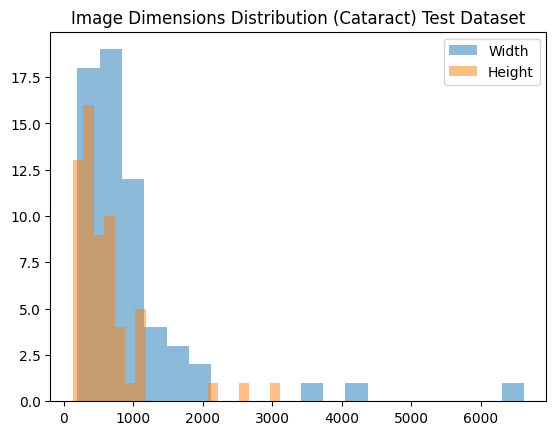

In [10]:
widths, heights = analyze_image_stats("/content/test/cataract")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Cataract) Test Dataset")
plt.show()

Max Width: 4220, Min Width: 69
Max Height: 2556, Min Height: 55


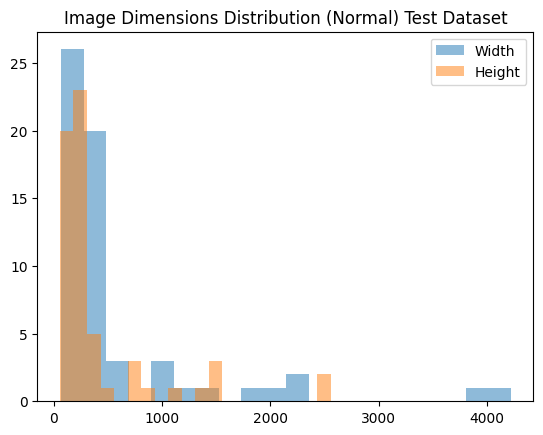

In [11]:
widths, heights = analyze_image_stats("/content/test/normal")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Normal) Test Dataset")
plt.show()

Preprocessing

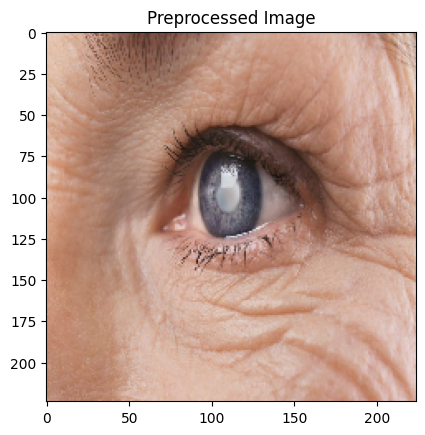

In [12]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalisasi [0, 1]
    return img

# Contoh preprocessing satu gambar
sample_img = preprocess_image("/content/train/cataract/image_155.png")
plt.imshow(sample_img)
plt.title("Preprocessed Image")
plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    "/content/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Binary classification (cataract vs normal)
    shuffle=True
)

# Generator untuk data test (hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1286 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


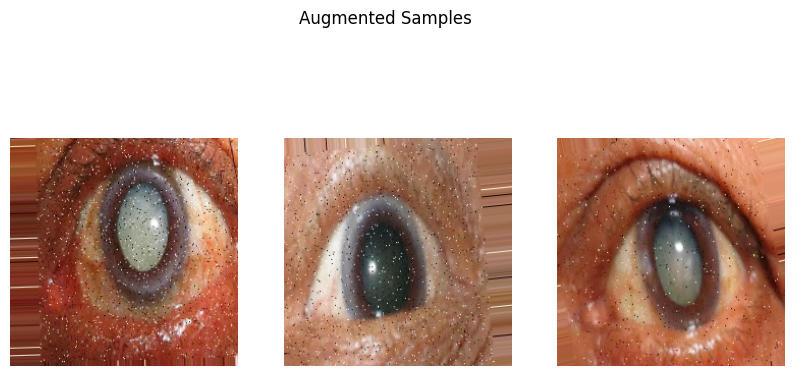

In [14]:
augmented_images, _ = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle("Augmented Samples")
plt.show()

In [15]:
print("Label Mapping:", train_generator.class_indices)
# Output harus: {'cataract': 0, 'normal': 1} atau sebaliknya

Label Mapping: {'cataract': 0, 'normal': 1}


In [16]:
import pandas as pd
from tqdm import tqdm

def save_preprocessed_data(generator, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    filenames, labels = [], []
    for i in tqdm(range(len(generator))):
        batch_x, batch_y = generator[i]
        for j in range(len(batch_x)):
            img_path = f"{save_dir}/img_{i}_{j}.png"
            cv2.imwrite(img_path, cv2.cvtColor(batch_x[j] * 255, cv2.COLOR_RGB2BGR))
            filenames.append(img_path)
            labels.append(batch_y[j])
    return pd.DataFrame({"filename": filenames, "label": labels})

# Contoh untuk train
df_train = save_preprocessed_data(train_generator, "/content/preprocessed_train")
df_train.to_csv("/content/train_metadata.csv", index=False)

100%|██████████| 41/41 [00:33<00:00,  1.21it/s]


# **Modelling**

In [17]:
#menggunakan callback jika data akurasi sudah 95%
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 # Import VGG16
from tensorflow.keras.optimizers import Adam # Import Adam

# Path ke data
train_dir = '/content/train'
test_dir  = '/content/test'

# Tentukan ukuran target gambar yang konsisten
image_target_size = (224, 224)

# Data generator (augmentasi hanya di train, rescale di kedua generator)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=40,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_target_size, # Ubah target_size menjadi 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_target_size, # Ubah target_size menjadi 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

def build_custom_model(num_classes, input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),  # Lebih stabil dibanding Flatten()
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



# (Optional) Callbacks: simpan best model dan early stopping
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]

#VGG16
def build_vgg16_model(num_classes, input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape) # Menggunakan input_shape yang disesuaikan
    base_model.trainable = False  # Freeze weights

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#resnet50
def build_resnet50_model(num_classes, input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape) # Menggunakan input_shape yang disesuaikan
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Found 1286 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


In [19]:
# Train model CNN custom
print("Training CNN Custom Model")
# Lewatkan input_shape ke fungsi pembangunan model
custom_model = build_custom_model(num_classes=train_generator.num_classes, input_shape=(224, 224, 3))
# Ringkasan arsitektur
custom_model.summary() # Ubah ini untuk mencetak ringkasan model custom

custom_history = custom_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)

Training CNN Custom Model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,018 (429.76 KB)

 Trainable params: 110,018 (429.76 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6807 - loss: 0.6219

41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 945ms/step - accuracy: 0.6805 - loss: 0.6215 - val_accuracy: 0.5041 - val_loss: 0.7297
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 917ms/step - accuracy: 0.6836 - loss: 0.5426 - val_accuracy: 0.5868 - val_loss: 0.7345
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 877ms/step - accuracy: 0.7155 - loss: 0.5216 - val_accuracy: 0.5702 - val_loss: 0.8463
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 816ms/step - accuracy: 0.7069 - loss: 0.5120 - val_accuracy: 0.5041 - val_loss: 0.9424
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 809ms/step - accuracy: 0.7444 - loss: 0.4736 - val_accuracy: 0.6612 - val_loss: 0.7543
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.7551 - loss: 0.4699

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 798ms/step - accuracy: 0.7550 - loss: 0.4700 - val_accuracy: 0.7190 - val_loss: 0.6399
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.7710 - loss: 0.4473

41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 895ms/step - accuracy: 0.7708 - loss: 0.4477 - val_accuracy: 0.7273 - val_loss: 0.6151
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 791ms/step - accuracy: 0.7470 - loss: 0.4670 - val_accuracy: 0.5950 - val_loss: 0.7191
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.7385 - loss: 0.4748

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 774ms/step - accuracy: 0.7386 - loss: 0.4746 - val_accuracy: 0.7355 - val_loss: 0.5876
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - accuracy: 0.7556 - loss: 0.4530 - val_accuracy: 0.7355 - val_loss: 0.6392
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.7672 - loss: 0.4472

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 813ms/step - accuracy: 0.7677 - loss: 0.4467 - val_accuracy: 0.7769 - val_loss: 0.5479
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 761ms/step - accuracy: 0.7914 - loss: 0.4124 - val_accuracy: 0.7521 - val_loss: 0.5525
Epoch 13/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 786ms/step - accuracy: 0.8047 - loss: 0.4231 - val_accuracy: 0.7603 - val_loss: 0.5629
Epoch 14/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.7919 - loss: 0.4286

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - accuracy: 0.7924 - loss: 0.4280 - val_accuracy: 0.7438 - val_loss: 0.5238
Epoch 15/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 809ms/step - accuracy: 0.8341 - loss: 0.3522 - val_accuracy: 0.7107 - val_loss: 0.6320
Epoch 16/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 798ms/step - accuracy: 0.8344 - loss: 0.3658 - val_accuracy: 0.7686 - val_loss: 0.5383
Epoch 17/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.8521 - loss: 0.3437

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 759ms/step - accuracy: 0.8522 - loss: 0.3435 - val_accuracy: 0.7603 - val_loss: 0.5077
Epoch 18/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.8288 - loss: 0.3665

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 781ms/step - accuracy: 0.8292 - loss: 0.3661 - val_accuracy: 0.7934 - val_loss: 0.4644
Epoch 19/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 766ms/step - accuracy: 0.8292 - loss: 0.3411 - val_accuracy: 0.7686 - val_loss: 0.5018
Epoch 20/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.8607 - loss: 0.3233

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 772ms/step - accuracy: 0.8608 - loss: 0.3230 - val_accuracy: 0.8099 - val_loss: 0.4272
Epoch 21/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 787ms/step - accuracy: 0.8741 - loss: 0.2810 - val_accuracy: 0.7769 - val_loss: 0.4565
Epoch 22/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 758ms/step - accuracy: 0.8394 - loss: 0.3297 - val_accuracy: 0.7603 - val_loss: 0.4642
Epoch 23/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.8734 - loss: 0.2947

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step - accuracy: 0.8734 - loss: 0.2946 - val_accuracy: 0.8678 - val_loss: 0.3743
Epoch 24/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8621 - loss: 0.2895

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 767ms/step - accuracy: 0.8622 - loss: 0.2895 - val_accuracy: 0.8512 - val_loss: 0.3599
Epoch 25/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 811ms/step - accuracy: 0.8853 - loss: 0.2735 - val_accuracy: 0.8182 - val_loss: 0.3910
Epoch 26/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 807ms/step - accuracy: 0.8873 - loss: 0.2918 - val_accuracy: 0.7851 - val_loss: 0.5575
Epoch 27/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 763ms/step - accuracy: 0.8825 - loss: 0.2800 - val_accuracy: 0.8017 - val_loss: 0.4213
Epoch 28/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9017 - loss: 0.2501

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 782ms/step - accuracy: 0.9016 - loss: 0.2501 - val_accuracy: 0.8678 - val_loss: 0.3229
Epoch 29/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 759ms/step - accuracy: 0.8998 - loss: 0.2438 - val_accuracy: 0.7851 - val_loss: 0.5103
Epoch 30/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 778ms/step - accuracy: 0.8976 - loss: 0.2389 - val_accuracy: 0.8843 - val_loss: 0.3354


In [20]:
# Train model VGG16
print("Training VGG16 Model")
# Lewatkan input_shape ke fungsi pembangunan model
vgg_model = build_vgg16_model(num_classes=train_generator.num_classes, input_shape=(224, 224, 3))
vgg_history = vgg_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)


Training VGG16 Model
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.6982 - loss: 0.6947

41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6997 - loss: 0.6904 - val_accuracy: 0.8760 - val_loss: 0.3029
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.8183 - loss: 0.3605

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 823ms/step - accuracy: 0.8190 - loss: 0.3595 - val_accuracy: 0.9174 - val_loss: 0.2460
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.8782 - loss: 0.2637

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - accuracy: 0.8777 - loss: 0.2644 - val_accuracy: 0.9091 - val_loss: 0.2206
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.8534 - loss: 0.2982

41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 849ms/step - accuracy: 0.8540 - loss: 0.2976 - val_accuracy: 0.9256 - val_loss: 0.2013
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8826 - loss: 0.2671

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 802ms/step - accuracy: 0.8830 - loss: 0.2668 - val_accuracy: 0.9339 - val_loss: 0.1863
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 842ms/step - accuracy: 0.8873 - loss: 0.2485 - val_accuracy: 0.9339 - val_loss: 0.1933
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.8879 - loss: 0.2422

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 832ms/step - accuracy: 0.8883 - loss: 0.2418 - val_accuracy: 0.9421 - val_loss: 0.1762
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 819ms/step - accuracy: 0.8966 - loss: 0.2400 - val_accuracy: 0.9091 - val_loss: 0.1968
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8881 - loss: 0.2524

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 823ms/step - accuracy: 0.8884 - loss: 0.2518 - val_accuracy: 0.9091 - val_loss: 0.1645
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9165 - loss: 0.1944

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 822ms/step - accuracy: 0.9165 - loss: 0.1948 - val_accuracy: 0.9256 - val_loss: 0.1544
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 884ms/step - accuracy: 0.9100 - loss: 0.2038 - val_accuracy: 0.9339 - val_loss: 0.1725
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9228 - loss: 0.1900

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 835ms/step - accuracy: 0.9226 - loss: 0.1901 - val_accuracy: 0.9256 - val_loss: 0.1483
Epoch 13/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 847ms/step - accuracy: 0.9127 - loss: 0.2039 - val_accuracy: 0.9174 - val_loss: 0.2120
Epoch 14/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 803ms/step - accuracy: 0.9253 - loss: 0.1773 - val_accuracy: 0.9256 - val_loss: 0.1605
Epoch 15/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 824ms/step - accuracy: 0.9280 - loss: 0.1689 - val_accuracy: 0.9339 - val_loss: 0.1513
Epoch 16/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 838ms/step - accuracy: 0.9280 - loss: 0.1833 - val_accuracy: 0.9256 - val_loss: 0.1620
Epoch 17/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.9178 - loss: 0.1839

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 822ms/step - accuracy: 0.9180 - loss: 0.1836 - val_accuracy: 0.9174 - val_loss: 0.1401
Epoch 18/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - accuracy: 0.9338 - loss: 0.1693 - val_accuracy: 0.9339 - val_loss: 0.1669
Epoch 19/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 821ms/step - accuracy: 0.9153 - loss: 0.1946 - val_accuracy: 0.9256 - val_loss: 0.1404
Epoch 20/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 818ms/step - accuracy: 0.9432 - loss: 0.1427 - val_accuracy: 0.9256 - val_loss: 0.1539
Epoch 21/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.9451 - loss: 0.1373

41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 856ms/step - accuracy: 0.9450 - loss: 0.1374 - val_accuracy: 0.9339 - val_loss: 0.1258
Epoch 22/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step - accuracy: 0.9409 - loss: 0.1602 - val_accuracy: 0.9504 - val_loss: 0.1264
Epoch 23/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 806ms/step - accuracy: 0.9542 - loss: 0.1322 - val_accuracy: 0.9421 - val_loss: 0.1486
Epoch 24/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 824ms/step - accuracy: 0.9459 - loss: 0.1304 - val_accuracy: 0.9421 - val_loss: 0.1278
Epoch 25/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 807ms/step - accuracy: 0.9440 - loss: 0.1382 - val_accuracy: 0.9421 - val_loss: 0.1357
Epoch 26/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.9325 - loss: 0.1633

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 826ms/step - accuracy: 0.9325 - loss: 0.1632 - val_accuracy: 0.9421 - val_loss: 0.1168
Epoch 27/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.9386 - loss: 0.1568

41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 851ms/step - accuracy: 0.9387 - loss: 0.1565 - val_accuracy: 0.9504 - val_loss: 0.1101
Epoch 28/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 819ms/step - accuracy: 0.9513 - loss: 0.1280 - val_accuracy: 0.9339 - val_loss: 0.1441
Epoch 29/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 810ms/step - accuracy: 0.9511 - loss: 0.1292 - val_accuracy: 0.9256 - val_loss: 0.1677
Epoch 30/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 829ms/step - accuracy: 0.9500 - loss: 0.1258 - val_accuracy: 0.9421 - val_loss: 0.1177


In [21]:
# Train model ResNet50
print("Training ResNet50 Model")
# Lewatkan input_shape ke fungsi pembangunan model
resnet_model = build_resnet50_model(num_classes=train_generator.num_classes, input_shape=(224, 224, 3))
resnet_history = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)

Training ResNet50 Model
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5575 - loss: 2.3258 - val_accuracy: 0.5124 - val_loss: 0.6876
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - accuracy: 0.6305 - loss: 0.6465 - val_accuracy: 0.5124 - val_loss: 0.6812
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 840ms/step - accuracy: 0.6915 - loss: 0.6239 - val_accuracy: 0.5041 - val_loss: 0.6891
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 788ms/step - accuracy: 0.6751 - loss: 0.6295 - val_accuracy: 0.5041 - val_loss: 0.7315
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 810ms/step - accuracy: 0.6810 - loss: 0.6275 - val_accuracy: 0.5041 - val_loss: 0.8119
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 825ms/step - accuracy: 0.6854 - loss: 0.6161 - val_accuracy: 0.5041 - val_loss: 0.7084
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 781ms/step - accuracy: 0.6898 - loss: 0.6171 - val_accuracy: 0.5041 - val_loss: 0.6934


# **Evaluasi dan Visualisasi**

In [22]:
models = {
    'Custom CNN': custom_model,
    'VGG16': vgg_model,
    'ResNet50': resnet_model
}

for name, model in models.items():
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"{name} Test Accuracy: {acc:.2%}")


Custom CNN Test Accuracy: 86.78%
VGG16 Test Accuracy: 95.04%
ResNet50 Test Accuracy: 51.24%


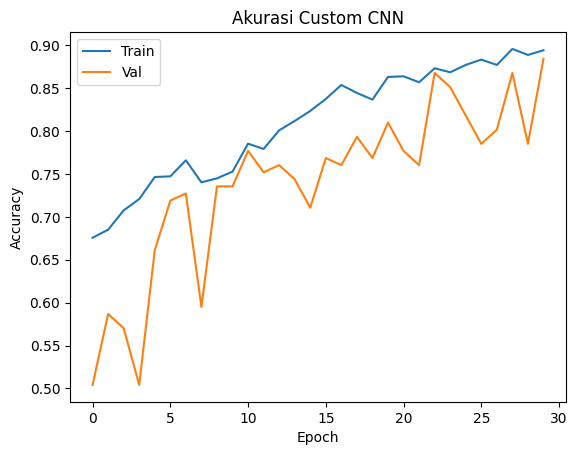

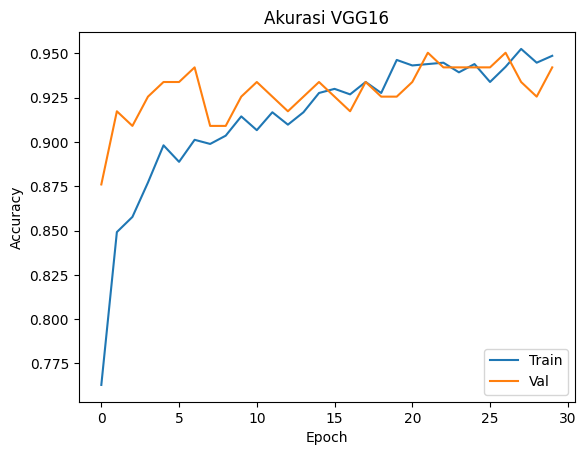

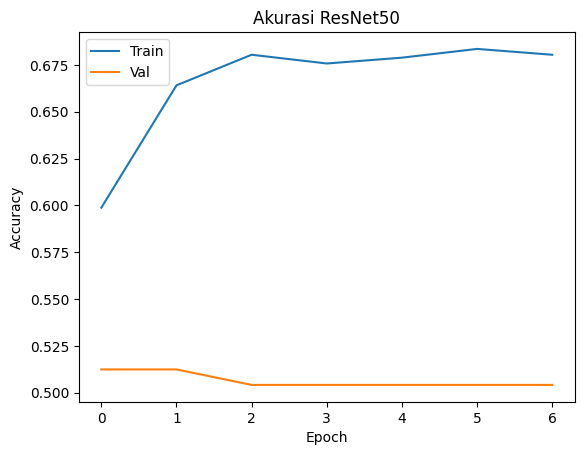

In [23]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Akurasi {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(custom_history, "Custom CNN")
plot_history(vgg_history, "VGG16")
plot_history(resnet_history, "ResNet50")


In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Definisikan fungsi untuk membuat plot confusion matrix
def plot_confusion_matrix(model, generator, title):
    """
    Fungsi ini menampilkan confusion matrix untuk model yang diberikan.

    Args:
      model: Model Keras yang sudah dilatih.
      generator: Generator data untuk set pengujian.
      title: Judul untuk grafik.
    """
    # 1. Lakukan prediksi pada data uji
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 2. Dapatkan label asli dari generator
    y_true = generator.classes

    # 3. Dapatkan nama-nama kelas
    class_labels = list(generator.class_indices.keys())

    # 4. Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # 5. Tampilkan heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step


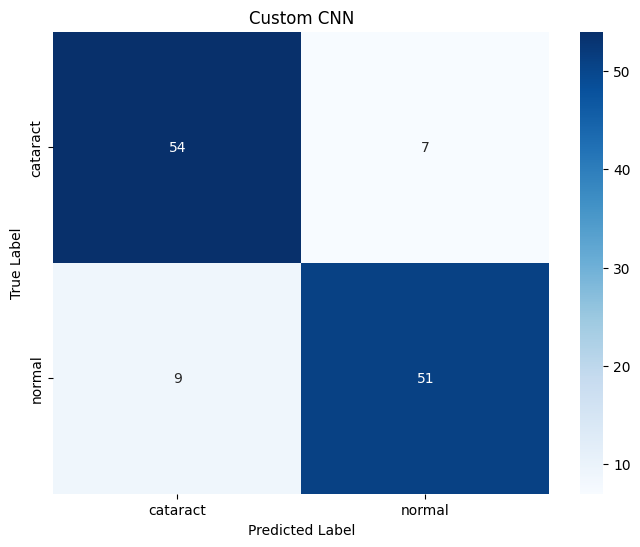

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 694ms/step


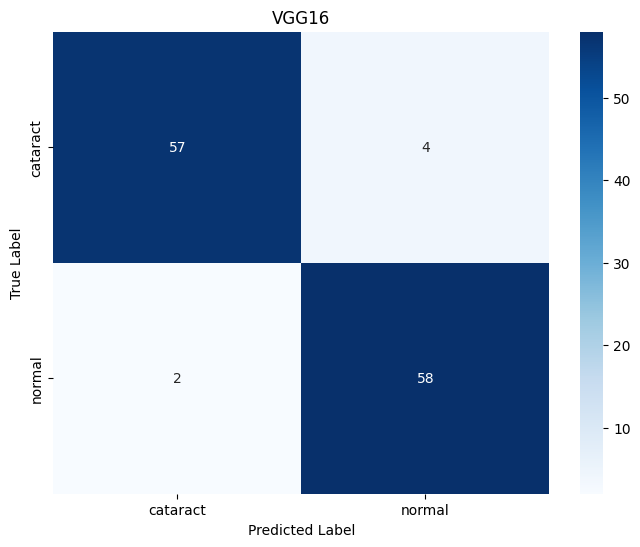

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


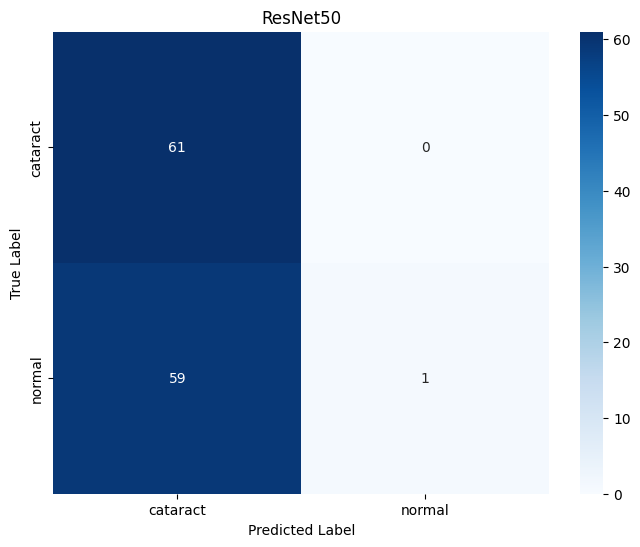

In [25]:
plot_confusion_matrix(custom_model, test_generator, "Custom CNN")
plot_confusion_matrix(vgg_model, test_generator, "VGG16")
plot_confusion_matrix(resnet_model, test_generator, "ResNet50")

In [27]:
custom_model.save('model_custom_cnn.keras')
vgg_model.save('model_vgg16.keras')
resnet_model.save('model_resnet50.keras')

print("Semua model berhasil disimpan dalam format .keras")

Semua model berhasil disimpan dalam format .keras


Saving download (2).jpg to download (2).jpg


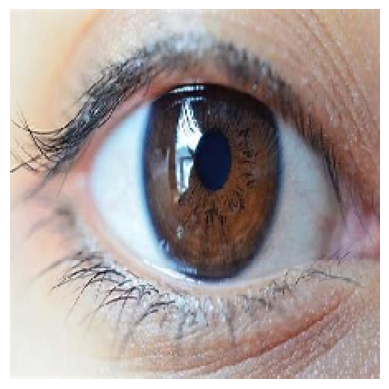

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: download (2).jpg
Prediction: Normal


In [28]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Mengunggah file gambar
uploaded = files.upload()

for fn in uploaded.keys():
  # Memuat dan menampilkan gambar yang diunggah
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Pra-pemrosesan gambar
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Normalisasi gambar

  # Melakukan prediksi
  images = np.vstack([x])
  classes = vgg_model.predict(images, batch_size=10)
  prediction = np.argmax(classes)

  # Menampilkan hasil prediksi
  print(f"File: {fn}")
  if prediction == 0:
    print('Prediction: Cataract')
  else:
    print('Prediction: Normal')

Saving download (3).jpg to download (3).jpg


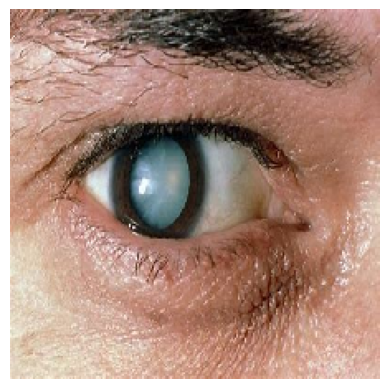

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
File: download (3).jpg
Prediction: Cataract


In [29]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Mengunggah file gambar
uploaded = files.upload()

for fn in uploaded.keys():
  # Memuat dan menampilkan gambar yang diunggah
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Pra-pemrosesan gambar
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Normalisasi gambar

  # Melakukan prediksi
  images = np.vstack([x])
  classes = vgg_model.predict(images, batch_size=10)
  prediction = np.argmax(classes)

  # Menampilkan hasil prediksi
  print(f"File: {fn}")
  if prediction == 0:
    print('Prediction: Cataract')
  else:
    print('Prediction: Normal')